## Create and run a local RAG pipeline from scratch

### What is RAG?

RAG stands for Retrieval Augmented Generation.

The goal of RAG is to take information and pass it to an LLM so it can generate outputs based on that information.

* Retrieval - Find relevant information given a query, e.g. "what are the macronutrients and what do they do?"  -> retrieve passages of text related to the macronutrients from a nutrition textbook.

* Augmented - We want to take the relevant information and augment our input (prompt) to an LLM with that relevant information.

* Generation - Take the first two steps and pass them to an LLM for generative outputs.

If you want to read where RAG came from, see the paper from Facebook AI: https://proceedings.neurips.cc/paper/2020/file/6b493230205f780e1bc26945df7481e5-Paper.pdf

> This work offers several positive societal benefits over previous work: the fact that it is more
strongly grounded in real factual knowledge (in this case Wikipedia) makes it “hallucinate” less
with generations that are more factual, and offers more control and interpretability. RAG could be
employed in a wide variety of scenarios with direct benefit to society, for example by endowing it
with a medical index and asking it open-domain questions on that topic, or by helping people be more
effective at their jobs.

### Why RAG?

The main goal of RAG is to improve the generation outputs of LLMs.

1. Prevent hallucinations - LLMs are incredibly good at generating good *looking* text, however, this text does not mean that it is factual. RAG can help LLMs generate information based on relevant passages that are factual.

2. Work with custom data - Many base LLMs are trained with internet-scale data. This means they have a fairly good understanding of language in general. However, it also does mean a lot of their responses can be generic in nature. RAG helps to create specific responses based on specific documents (e.g. your own companies customer support documents).


### What can RAG be used for?

* Customer support Q&A chat - Treat your existing support documents as a resource and when a customer asks a question, you could have a retrieval system , retrieve relevant documentation snippets and then have an LLM craft those snippets into and answer. Think of this as a "chatbot" for your documentation.

* Email chain analysis - Let's say you're a large insurance company and you have chains and chains of emails of customer claims. You could use a RAG pipeline to find relevant information from those emails and then use an LLM to process that information into structured data.

* Company internal documentation chat

* Textbook Q&A - Let's say you are a nutrition student and you have got a 1200 page textbook to read, you could build a RAG pipeline to go through the textbook and find relevant passages to the questions you have.

Common theme here: take your relevant documents to a query and process them with an LLM.

From this angle, you can consider an LLM as a calculator for words.


### Why Local ?

Fun.

Privacy, speed and cost.

* Privacy - If you have private documentation, may be you do not want to send that to an API. You want to setup an LLM and run it on your own hardware.

* Speed - Whenever you use an API, you have to send some kind of data across the internet. This takes time. Running locally means we do not have to wait for transfers of data.

* Cost - If you own your hardware, the cost is paid. It may have a large cost to begin with. But overtime, you do not have to keep paying API fees.

* No vendor lockin - If you run your own software/hardware. If OpenAI/another large internet company shut down tomorrow, you can still run your business.

In [82]:
!nvidia-smi

Wed Dec 10 19:00:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P0             27W /   70W |    6796MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### What we are going to build

* https://github.com/mrdbourke/simple-local-rag
* https://whimsical.com/simple-local-rag-workflow-39kToR3yNf7E8kY4sS2tjV

We are going to build NutriChat to "chat with a nutrition textbook".

Specifically:

1. Open a PDF document (you could use almost any PDF here or even a collection of PDFs).

2. Format the text of the PDF textbook ready for an embedding model.

3. Embed all of the chunks of text in the textbook and turn them into numerical representations which we can store for later.

4. Build a retrieval system that uses vector search to find relevant chunk of text based on a query.

5. Create a prompt that incorporates the retrieved pieces of text.

6. Generate an answer to a query based on the passages of the textbook with an LLM.

1. Steps 1-3: Document preprocessing and embedding creation.

2. Steps 4-6: Search and answer

### 1. Document/text processing and embedding creation

Ingredients:

* PDF document of choice (note: this could be almost any kind of document, I have just chosen to focus on PDFs for now).

* Embedding model of choice.

Steps:

1. Import PDF document.

2. Process text for embedding (e.g. split into chunks of sentences).

3. Embed text chunks with embedding model.

4. Save embeddings file for later (embeddings will store on file for many years or until you lose your hard drive).



In [83]:
#### Import PDF document
# !wget https://github.com/mrdbourke/simple-local-rag/blob/main/human-nutrition-text.pdf

In [84]:
import os
import requests

# Get PDF document path
pdf_path = "human-nutrition-text.pdf"

# Download PDF
if not os.path.exists(pdf_path):
  print(f"File does not exist, downloading...")

  # Enter the URL of the pdf
  url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request is successful
  if response.status_code == 200:
    # Open the file and save it
    with open(filename, "wb") as file:
      file.write(response.content)
    print(f"[INFO] the file has been downloaded and saved as {filename}")
  else:
    print(f"[INFO] failed to download the file. Status code: {response.status_code}")

else:
  print(f"File {pdf_path} exists.")

File human-nutrition-text.pdf exists.


We have got a PDF, let's open it!

In [85]:
!pip install PyMuPDF

In [86]:
import fitz  # requires pip install PyMuPDF, see: https://github.com/pymupdf/PyMuPDF
from tqdm.auto import tqdm # pip install tqdm

In [87]:
def text_formatter(text: str) -> str:
  """
  Performs minor formatting on text.
  """
  cleaned_text = text.replace("\n", " ").strip()

  # Potentially more text formatting function can go here
  return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
  doc = fitz.open(pdf_path)
  pages_and_texts = []
  for page_number, page in tqdm(enumerate(doc)):
    text = page.get_text()
    text = text_formatter(text=text)
    pages_and_texts.append({"page_number": page_number - 41,
                            "page_char_count": len(text),
                            "page_word_count": len(text.split(" ")),
                            "page_sentence_count_raw": len(text.split(". ")),
                            "page_token_count": len(text) / 4, # 1 token ~ 4 characters
                            "text": text
                          })
  return pages_and_texts


pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)

0it [00:00, ?it/s]

In [88]:
pages_and_texts[:2]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [89]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 1047,
  'page_char_count': 1437,
  'page_word_count': 241,
  'page_sentence_count_raw': 12,
  'page_token_count': 359.25,
  'text': 'obesity and more about simply getting enough to eat. In today’s  industrialized nations, conveniences have solved some problems  and introduced new ones, including the hand-in-hand obesity and  diabetes epidemics. Fad diets gained popularity as more North  Americans struggled with excess pounds. However, new evidence- based approaches that emphasize more holistic measures are on  the rise. These new dietary trends encourage those seeking to lose  weight to eat healthy, whole foods first, while adopting a more  active lifestyle. These sound practices put dietary choices in the  context of wellness and a healthier approach to life.  Everyday Connections  In the past, people’s culture and location determined the  foods they ate and the manner in which they prepared their  meals. For example, in Hawai‘i, taro was a staple complex  carbohydrat

In [90]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...


In [91]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00
std,348.86,560.38,95.76,6.19,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,4.00,190.50
50%,562.50,1231.50,214.50,10.00,307.88
75%,864.25,1603.50,271.00,14.00,400.88
max,1166.00,2308.00,429.00,32.00,577.00


Why would we care about token count?

Token count is important to think about, because:

1. Embedding models do not deal with infinite tokens.
2. LLMs do not deal with infinite tokens.

For example, an embedding model may have been trained to embed sequences of 384 tokens into numerical space (sentence-transformers `all-mpnet-base-v2`, see: https://sbert.net/docs/cross_encoder/pretrained_models.html)

As for LLMs, they can't accept infinite tokens in their context window.

### Further text processing (splitting pages into sentences)

Two ways to do this:

1. We have done this by splitting on `". "`.

2. We can do this with a NLP library such as spaCy (https://spacy.io/usage) and nltk (https://www.nltk.org/).


In [92]:
from spacy.lang.en import English

nlp = English()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer
nlp.add_pipe("sentencizer")

# Create document instance as an example
doc = nlp("This is a sentence. This another sentence. I like elephants.")
assert len(list(doc.sents)) == 3

# Print out our sentences split
list(doc.sents)

[This is a sentence., This another sentence., I like elephants.]

In [93]:
pages_and_texts[600]

{'page_number': 559,
 'page_char_count': 863,
 'page_word_count': 136,
 'page_sentence_count_raw': 8,
 'page_token_count': 215.75,
 'text': 'Image by  Allison  Calabrese /  CC BY 4.0  Korsakoff syndrome can cause similar symptoms as beriberi such  as confusion, loss of coordination, vision changes, hallucinations,  and may progress to coma and death. This condition is specific  to alcoholics as diets high in alcohol can cause thiamin deficiency.  Other individuals at risk include individuals who also consume diets  typically low in micronutrients such as those with eating disorders,  elderly, and individuals who have gone through gastric bypass  surgery.5  Figure 9.10 The Role of Thiamin  Figure 9.11 Beriberi, Thiamin Deficiency  5.\xa0Fact Sheets for Health Professionals: Thiamin. National  Institute of Health, Office of Dietary Supplements.  \xa0https://ods.od.nih.gov/factsheets/Thiamin- HealthProfessional/. Updated Feburary 11, 2016.  Accessed October 22, 2017.  Water-Soluble Vitami

In [94]:
for item in tqdm(pages_and_texts):
  item["sentences"] = list(nlp(item["text"]).sents)

  # Make sure all sentences are strings (default type is a spaCy datatype)
  item["sentences"] = [str(sentence) for sentence in item["sentences"]]

  # Count the sentences
  item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [95]:
random.sample(pages_and_texts, k=1)

[{'page_number': 684,
  'page_char_count': 1026,
  'page_word_count': 212,
  'page_sentence_count_raw': 14,
  'page_token_count': 256.5,
  'text': 'Food  Serving  Iodine (mcg) Percent Daily Value  Seaweed  1 g.  16 to 2,984  11 to 1,989  Cod fish  3 oz.  99  66  Yogurt, low fat  8 oz.  75  50  Iodized salt  1.5 g.  71  47  Milk, reduced fat  8 oz.  56  37  Ice cream, chocolate ½ c.  30  20  Egg  1 large  24  16  Tuna, canned  3 oz.  17  11  Prunes, dried  5 prunes  13  9  Banana  1 medium 3  2  Health Professional Fact Sheet: Iodine. National Institute of Health,  Office of Dietary Supplements. https://ods.od.nih.gov/factsheets/ Iodine-HealthProfessional/. Updated June 24, 2011. Accessed  November 10, 2017.  Learning Activities  Technology Note: The second edition of the Human  Nutrition Open Educational Resource (OER) textbook  features interactive learning activities.\xa0 These activities are  available in the web-based textbook and not available in the  downloadable versions (EPUB, 

In [96]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00,10.32
std,348.86,560.38,95.76,6.19,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,4.00,190.50,5.00
50%,562.50,1231.50,214.50,10.00,307.88,10.00
75%,864.25,1603.50,271.00,14.00,400.88,15.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00


### Chunking our sentences together

The concept of splitting larger pieces of text into smaller ones is often referred to as text splitting or chunking.

There is no 100% correct way to do this.

We will keep it simple and split it into groups of 10 sentences (however, you could also try 5, 7, 8, whatever you like).

There are frameworks such as LangChain which can help with this, however stick with Python for now:
https://python.langchain.com/docs/modules/data_connection/document_transformers/

Why we do this:

1. So our texts are easier to filter (smaller groups of text can be easier to inspect than large passages of text).

2. So our text chunks can fit into our embedding model context window (e.g. 384 tokens as a limit).

3. So our contexts passed to an LLM can be more specific and focused.

In [97]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

# Create a function to split lists of texts recursively into chunk size
# e.g. [20] -> [10, 10] or [25] -> [10, 10, 5]

def split_list(input_list: list,
               slice_size: int=num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i: i + slice_size] for i in range(0, len(input_list), slice_size)]

test_list = list(range(25))
split_list(test_list)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [98]:
# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
  item["sentence_chunks"] = split_list(input_list = item["sentences"],
                                       slice_size = num_sentence_chunk_size)
  item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [99]:
random.sample(pages_and_texts, k=1)

[{'page_number': 107,
  'page_char_count': 2280,
  'page_word_count': 379,
  'page_sentence_count_raw': 16,
  'page_token_count': 570.0,
  'text': 'in the endocrine system are the pituitary, thyroid, parathyroid,  adrenals, thymus, pineal, pancreas, ovaries, and testes. The glands  secrete hormones, which are biological molecules that regulate  cellular processes in other target tissues, so they require  transportation by the circulatory system. Adequate nutrition is  critical for the functioning of all the glands in the endocrine system.  A protein deficiency impairs gonadal-hormone release, preventing  reproduction. Athletic teenage girls with very little body fat often  do not menstruate. Children who are malnourished usually do not  produce enough growth hormone and fail to reach normal height  for their age group. Probably the most popularized connection  between nutrition and the functions of the endocrine system is  that unhealthy dietary patterns are linked to obesity and the  

In [100]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00,10.32,1.53
std,348.86,560.38,95.76,6.19,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,4.00,190.50,5.00,1.00
50%,562.50,1231.50,214.50,10.00,307.88,10.00,1.00
75%,864.25,1603.50,271.00,14.00,400.88,15.00,2.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00,3.00


### Splitting each chunk into its own item

We would like to embed each chunk of sentences into its own numerical representation.

That'll give us a good level of granularity.

Meaning, we can dive specifically into text sample that was used in our model.

In [101]:
import re

# Split each chunk into its own item
pages_and_chunks = []

for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into paragraph like structure, aka join the list of sentences into one paragraph
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk)  #  ".A" => ". A" (will work for any capital letter)

        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get some stats on our chunks
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4  # 1 token = ~ 4 chunks

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [102]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 1085,
  'sentence_chunk': '6.\xa0Diverticular Disease. National Institute of Diabetes and Digestive and Kidney Diseases, National Institute of Health.http://digestive.niddk.nih.gov/ddiseases/pubs/ diverticulosis/. Accessed April 15, 2018. 7.\xa0Diverticular Disease. National Institute of Diabetes and Digestive and Kidney Diseases, National Institute of Health.http://digestive.niddk.nih.gov/ddiseases/pubs/ diverticulosis/. Accessed April 15, 2018. Nutrition, Health and Disease | 1085',
  'chunk_char_count': 454,
  'chunk_word_count': 46,
  'chunk_token_count': 113.5}]

In [103]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.44,112.33,183.61
std,347.79,447.54,71.22,111.89
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,44.00,78.75
50%,586.00,746.00,114.00,186.50
75%,890.00,1118.50,173.00,279.62
max,1166.00,1831.00,297.00,457.75


#### Filter chunks of text for short chunks

These chunks may not contain much useful information.

In [104]:
df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count
0,-41,Human Nutrition: 2020 Edition,29,4,7.25
1,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00
2,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50
3,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50
4,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25


In [105]:
# Show random chunks with under 30 tokens in length
min_token_length = 30

for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 13.25 | Text: https://doi.org/10.1186/ 1743-7075-4-24. Sulfur | 637
Chunk token count: 14.75 | Text: Folate is also found in legumes, liver, and Pregnancy | 787
Chunk token count: 19.25 | Text: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=463   870 | Introduction
Chunk token count: 21.0 | Text: Updated September 2003. Accessed November 28,2017. Discovering Nutrition Facts | 735
Chunk token count: 12.5 | Text: Figure 11.2 The Structure of Hemoglobin Iron | 655


In [106]:
# Filter our Dataframe for rows with under 30 tokens
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [107]:
random.sample(pages_and_chunks_over_min_token_len, k=1)

[{'page_number': 410,
  'sentence_chunk': 'Most nitrogen is lost as urea in the urine, but urea is also excreted in the feces. Proteins are also lost in sweat and as hair and nails grow. The RDA, therefore, is the amount of protein a person should consume in their diet to balance the amount of protein used up and lost from the body. For healthy adults, this amount of protein was determined to be 0.8 grams of protein per kilogram of body weight. You can calculate 410 | Proteins, Diet, and Personal Choices',
  'chunk_char_count': 466,
  'chunk_word_count': 87,
  'chunk_token_count': 116.5}]

### Embedding our text chunks

Embeddings are a broad but powerful concept.

While humans understand texts, machines understand numbers.

What we'd like to do:

- Turn our text chunks into numbers, specifically embeddings.

A useful numerical representation.

The best part about embeddings is that they are a *learned* representation.

```
{"the":0,
"a": 1,
...
```

For a great resource on learning embeddings, see here: https://vickiboykis.com/what_are_embeddings/


In [108]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cpu")

# Create a list of sentences
sentences = ["The Sentence Transformer library provides an easy way to create embeddings",
             "Sentences can be embedded one by one or in a list.",
             "I like horses!"]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print(f"Sentence: {sentence}")
    print(f"Embedding: {embedding}")
    print("")

Sentence: The Sentence Transformer library provides an easy way to create embeddings
Embedding: [-3.17513272e-02  3.37267667e-02 -2.52437480e-02  5.22288382e-02
 -2.35249884e-02 -6.19112561e-03  1.35025363e-02 -6.25501126e-02
  7.50832027e-03 -2.29685158e-02  2.98145954e-02  4.57555801e-02
 -3.26700583e-02  1.39847510e-02  4.18013521e-02 -5.92969358e-02
  4.26310077e-02  5.04655857e-03 -2.44552679e-02  3.98590742e-03
  3.55898216e-02  2.78742798e-02  1.84098575e-02  3.67699526e-02
 -2.29961760e-02 -3.01796962e-02  5.99625870e-04 -3.64504606e-02
  5.69104701e-02 -7.49941776e-03 -3.70004103e-02 -3.04363156e-03
  4.64355052e-02  2.36152252e-03  9.06849607e-07  7.00036949e-03
 -3.92289497e-02 -5.95698087e-03  1.38653601e-02  1.87104940e-03
  5.34202680e-02 -6.18613772e-02  2.19613407e-02  4.86051366e-02
 -4.25697491e-02 -1.69859026e-02  5.04178330e-02  1.54733453e-02
  8.12860429e-02  5.07106334e-02 -2.27497108e-02 -4.35721353e-02
 -2.18388508e-03 -2.14091465e-02 -2.01758351e-02  3.0683202

In [109]:
embeddings[0].shape

(768,)

In [110]:
embedding = embedding_model.encode("My favorite animal is the cow!")
embedding

array([-1.45920627e-02,  8.02743807e-02, -2.35814396e-02, -3.19281891e-02,
        4.08717766e-02,  5.27201146e-02, -6.59843013e-02,  1.63272973e-02,
        1.03795659e-02, -3.25809307e-02, -2.78963018e-02,  5.04058562e-02,
       -3.03210132e-02, -5.52537572e-03, -2.25000829e-03, -3.40672955e-02,
        4.15263511e-02, -6.02296926e-03, -1.18760616e-02,  5.03419824e-02,
       -2.46708803e-02,  4.90849316e-02, -1.78524721e-02, -2.02774964e-02,
       -3.04977596e-02,  8.45100638e-03, -2.10024752e-02, -2.69277133e-02,
        1.77504309e-02,  1.21456487e-02, -5.96181042e-02, -8.12657773e-02,
        3.16369571e-02, -1.59014529e-03,  1.23865732e-06, -8.03152192e-03,
       -3.90660055e-02,  2.38244962e-02,  3.93481478e-02,  2.12702528e-03,
        2.04685405e-02,  4.92229313e-03, -2.50347555e-02,  1.32805891e-02,
        3.23007032e-02,  5.64529672e-02,  4.20428738e-02,  1.70866977e-02,
       -9.11563411e-02,  1.88812017e-02, -3.20625538e-03,  4.00580961e-04,
       -3.64725515e-02,  

In [111]:
%%time

# embedding_model.to("cpu")

# # Embed each chunk one by one
# for item in tqdm(pages_and_chunks_over_min_token_len):
#     item["embedding"] = embedding_model.encode(item["sentence_chunk"])

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


In [112]:
%%time

embedding_model.to("cuda")

for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 34.7 s, sys: 201 ms, total: 34.9 s
Wall time: 47.2 s


In [113]:
%%time

text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

text_chunks[419]

CPU times: user 555 µs, sys: 0 ns, total: 555 µs
Wall time: 688 µs


'often. • Calm your “sweet tooth” by eating fruits, such as berries or an apple. • Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacity. The differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foods. Molecular gastronomists use slow- releasing carbohydrates, such as alginate, to give shape and texture to their fascinating food creations. Add

In [114]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                                batch_size = 32,  # you can experiment to find which batch size leads to best results
                                                convert_to_tensor = True)

text_chunk_embeddings

CPU times: user 24.2 s, sys: 40.9 ms, total: 24.2 s
Wall time: 23.8 s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

#### Save embeddings to file



In [115]:
pages_and_chunks_over_min_token_len[419]

{'page_number': 277,
 'sentence_chunk': 'often. • Calm your “sweet tooth” by eating fruits, such as berries or an apple. • Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacity. The differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foods. Molecular gastronomists use slow- releasing carbohydrates, such as alginate, to give shape and texture 

In [116]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)

embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [117]:
# Import saved file and view
text_chunks_and_embeddings_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embeddings_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242675e-02 9.02281404e-02 -5.09548886e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156419e-02 5.92139773e-02 -1.66167244e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,[ 2.79801842e-02 3.39813754e-02 -2.06426680e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,[ 6.82566911e-02 3.81275006e-02 -8.46854132e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264494e-02 -8.49763490e-03 9.57159605e-...


If your embedding databse is really large (e.g. over 100k-1M samples) you might want to look into using a vector database for storage:
https://en.wikipedia.org/wiki/Vector_database

### 2. RAG -Search and Answer

RAG goal: Retrieve relevant passages based on a query and use those passages to augment an input to an LLM so it can generate an output based on those relevant passages.

### Similarity search

Embeddings can be used for almost any time of data.

For example, you can turn images into embeddings, sound into embeddings, text into embeddings, etc...

Comparing embeddings is known as similarity search, vector search, semantic search.

In our case, we want to query our nutrition textbook passages based on semantics or "vibe".

So if I search for "macronutrient nutrition" I should get relevant passages to that text but may not contain exactly the words "macronutrient functions".

Whereas with keyword search, if I search "apple" I get back passages with specifically "apple".


In [118]:
import random

import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert our embeddings into a torch.tensor
embeddings = torch.tensor(np.stack(text_chunks_and_embedding_df['embedding'].tolist(), axis=0), dtype=torch.float32).to(device)

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

text_chunks_and_embedding_df

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242675, 0.0902281404, -0.00509548886, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156419, 0.0592139773, -0.0166167244, -0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,"[0.0279801842, 0.0339813754, -0.020642668, 0.0..."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,"[0.0682566911, 0.0381275006, -0.00846854132, -..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264494, -0.0084976349, 0.00957159605, -..."
...,...,...,...,...,...,...
1675,1164,Flashcard Images Note: Most images in the flas...,1305,176,326.25,"[0.0185622536, -0.0164277665, -0.0127045633, -..."
1676,1164,Hazard Analysis Critical Control Points reused...,375,51,93.75,"[0.0334720612, -0.0570440851, 0.0151489386, -0..."
1677,1165,ShareAlike 11. Organs reused “Pancreas Organ A...,1286,173,321.50,"[0.0770515501, 0.00978557579, -0.0121817412, 0..."
1678,1165,Sucrose reused “Figure 03 02 05” by OpenStax B...,410,59,102.50,"[0.103045158, -0.0164701864, 0.00826846063, 0...."


In [119]:
embeddings.shape

torch.Size([1680, 768])

In [120]:
# Create model
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path = "all-mpnet-base-v2",
                                      device=device)

Embedding model ready!

Let's create a small semantic search pipeline.

In essence, we want to search for a query (e.g. "macronutrient functions") and get back relevant passages from our textbook.

We can do so with the following steps:

1. Define a query string.

2. Turn the query string into and embedding.

3. Perform a dot product or cosine similarity function between the text embeddings and the query embedding.

4. Sort the results from 3 in descending order.

In [121]:
embeddings.shape

torch.Size([1680, 768])

Note: to use dot product for comparison, ensure vector sizes of same shape (e.g.768) and tensors/vectors are in the same datatype (e.g. both are in torch.float32)

In [122]:
# 1. Define the query
query = "good foods for protein"
print(f"Query: {query}")

# 2. Embed the query
# Note: It is important to embed the query with the same model you embedded your passages
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to("cuda")

# 3. Get similarity scores with the dot product (use cosine similarity if outputs of model are'nt normalized)
from time import perf_counter as timer

start_time = timer()

dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]

end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time - start_time: .5f} seconds.")

# 4. Get the top-k results (we will keep top 5)
top_results_dot_product = torch.topk(dot_scores, k=5)

top_results_dot_product

Query: good foods for protein
[INFO] Time taken to get scores on 1680 embeddings:  0.00019 seconds.


torch.return_types.topk(
values=tensor([0.7729, 0.7647, 0.6743, 0.6743, 0.6634], device='cuda:0'),
indices=tensor([611, 616, 615, 620, 617], device='cuda:0'))

In [123]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(larger_embeddings)} embeddings: {end_time - start_time: .5f} seconds.")

Embeddings shape: torch.Size([168000, 768])
[INFO] Time taken to get scores on 168000 embeddings:  0.00065 seconds.


We can see that searching over embeddings is very fast even if we do exhaustive search.

But if you had 10M+ embeddings, you likely want to create an index.

An index is like letters in a dictionary.

For example, if you wanted to search "duck" in the dictionary, you would start at "d" then find words close to "du.." etc.

An index helps to narrow it down.

A popular indexing library for vector search is Faiss, see here:
https://github.com/facebookresearch/faiss

One technique that library provides is approximate nearest neighbor search (ANN):  https://en.wikipedia.org/wiki/(1%2B%CE%B5)-approximate_nearest_neighbor_search

Let's make our vector search results pretty.

In [124]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [125]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indices from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]['sentence_chunk'])
    print(f"Page number: {pages_and_chunks[idx]["page_number"]}")
    print("\n")

Query: 'good foods for protein'

Results:
Score: 0.7729
Text:
Dietary Sources of Protein The protein food group consists of foods made from
meat, seafood, poultry, eggs, soy, dry beans, peas, and seeds. According to the
Harvard School of Public Health, “animal protein and vegetable protein probably
have the same effects on health. It’s the protein package that’s likely to make
a difference.”1 1. Protein: The Bottom Line. Harvard School of Public Proteins,
Diet, and Personal Choices | 411
Page number: 411


Score: 0.7647
Text:
Additionally, a person should consume 8 ounces of cooked seafood every week
(typically as two 4-ounce servings) to assure they are getting the healthy
omega-3 fatty acids that have been linked to a lower risk for heart disease.
Another tip is choosing to eat dry beans, peas, or soy products as a main dish.
Some of the menu choices include chili with kidney and pinto beans, hummus on
pita bread, and black bean enchiladas. You could also enjoy nuts in a variety of
w

**Note:** We could potentially improve the order of these results with a reranking model. A model that has been trained specifically to take search results (e.g. the top 25 semantic results) and rank them in order from most likely top-1 to least likely.

See here for an open source reranking model: https://huggingface.co/mixedbread-ai/mxbai-rerank-large-v1

To check our results, what if we wanted to automatically surface the page of texts related to our query?

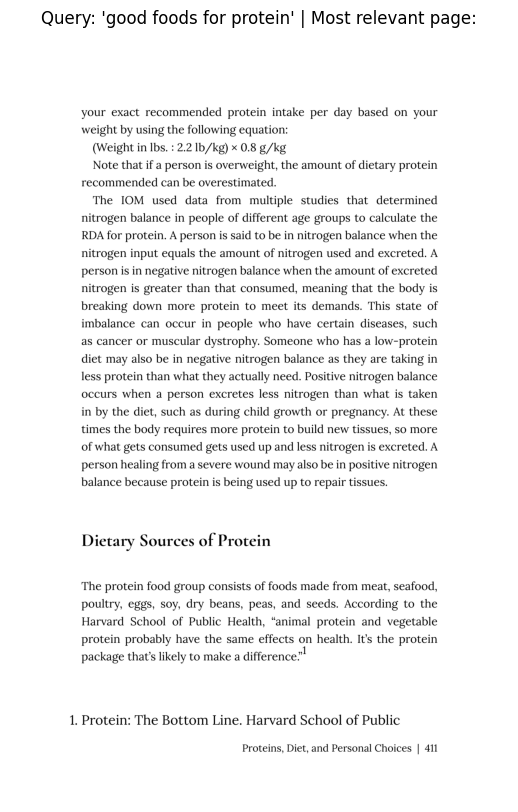

In [126]:
import fitz  # pymupdf library

# Open the pdf and load the target page
pdf_path = "human-nutrition-text.pdf"

doc = fitz.open(pdf_path)
page = doc.load_page(411 + 41) # note: page numbers of our PDF start

# Get the image of the page
img = page.get_pixmap(dpi = 300)

# Save image (optional)
# img.save("output_filename.png")
doc.close()

# Convert the pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13,10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis("off")
plt.show()

### Similarity measures: dot product and cosine similarities

Two of the most common similarity measures between vectors are dot products and cosine similarity.

In essence, closer vectors will have higher scores, further away vectors will have lower scores.

Vectors have direction (which way is it going?) and magnitude (how long is it?).

In [127]:
embeddings[0]

tensor([ 6.7424e-02,  9.0228e-02, -5.0955e-03, -3.1755e-02,  7.3908e-02,
         3.5198e-02, -1.9799e-02,  4.6769e-02,  5.3573e-02,  5.0123e-03,
         3.3393e-02, -1.6222e-03,  1.7608e-02,  3.6265e-02, -3.1668e-04,
        -1.0712e-02,  1.5426e-02,  2.6218e-02,  2.7765e-03,  3.6494e-02,
        -4.4411e-02,  1.8936e-02,  4.9012e-02,  1.6402e-02, -4.8578e-02,
         3.1829e-03,  2.7299e-02, -2.0476e-03, -1.2283e-02, -7.2805e-02,
         1.2045e-02,  1.0730e-02,  2.1000e-03, -8.1777e-02,  2.6783e-06,
        -1.8143e-02, -1.2080e-02,  2.4717e-02, -6.2747e-02,  7.3544e-02,
         2.2162e-02, -3.2877e-02, -1.8010e-02,  2.2295e-02,  5.6137e-02,
         1.7951e-03,  5.2593e-02, -3.3174e-03, -8.3387e-03, -1.0628e-02,
         2.3192e-03, -2.2393e-02, -1.5301e-02, -9.9306e-03,  4.6532e-02,
         3.5747e-02, -2.5476e-02,  2.6369e-02,  3.7491e-03, -3.8268e-02,
         2.5833e-02,  4.1287e-02,  2.5818e-02,  3.3297e-02, -2.5178e-02,
         4.5152e-02,  4.4907e-04, -9.9662e-02,  4.9

In [128]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example vectors/tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


### Functionizing our semantic search pipeline

Let's put all of the steps above for semantic search into a function or two so we can repeat the workflow.

In [129]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool = True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Get dot product scores on embeddings
    start_time = timer()
    dot_score = util.dot_score(a=query_embedding, b=embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time - start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_score,
                                 k=n_resources_to_return)

    return scores, indices


def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict] = pages_and_chunks,
                                 n_resources_to_return: int = 5):
    """
    Finds relevant passages given a query and prints them out along with their scores.
    """
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings = embeddings,
                                                  n_resources_to_return = n_resources_to_return)

    # Loop through zipped together scores and indices from torch.topk
    for score, idx in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print("Text:")
        print_wrapped(pages_and_chunks[idx]['sentence_chunk'])
        print(f"Page number: {pages_and_chunks[idx]["page_number"]}")
        print("\n")

In [130]:
query = "foods high in fiber"
retrieve_relevant_resources(query=query, embeddings=embeddings)

[INFO] Time taken to get scores on 1680 embeddings: 0.00008 seconds.


(tensor([0.6964, 0.6810, 0.5566, 0.5344, 0.5187], device='cuda:0'),
 tensor([ 418,  360,  358, 1047,  412], device='cuda:0'))

In [131]:
print_top_results_and_scores(query=query, embeddings=embeddings)

[INFO] Time taken to get scores on 1680 embeddings: 0.00007 seconds.
Score: 0.6964
Text:
• Change it up a bit and experience the taste and satisfaction of other whole
grains such as barley, quinoa, and bulgur. • Eat snacks high in fiber, such as
almonds, pistachios, raisins, and air-popped popcorn. Add an artichoke and green
peas to your dinner plate more 276 | Carbohydrates and Personal Diet Choices
Page number: 276


Score: 0.6810
Text:
Dietary fiber is categorized as either water-soluble or insoluble. Some examples
of soluble fibers are inulin, pectin, and guar gum and they are found in peas,
beans, oats, barley, and rye. Cellulose and lignin are insoluble fibers and a
few dietary sources of them are whole-grain foods, flax, cauliflower, and
avocados. Cellulose is the most abundant fiber in plants, making up the cell
walls and providing structure. Soluble fibers are more easily accessible to
bacterial enzymes in the large intestine so they can be broken down to a greater
extent than

### Getting an LLM for Local Generation

We want to focus on local generation.

However, this process will also work with an LLM API.

What is a generative LLM?

Goes from text input -> generate text output

Which LLM should I use?

* How much hardware VRAM do you have available?

#### Checking our local GPU memory availability


In [132]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 15 GB


In [133]:
!nvidia-smi

Wed Dec 10 19:02:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   71C    P0             36W /   70W |    8046MiB /  15360MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Note:

* to use `gemma-7b-it` or other Gemma models, you have to accept terms and conditions on Hugging Face: https://huggingface.co/google/gemma-7b-it

* to download models and run it locally from Hugging Face, you may need to sign in to the Hugging Face CLI.

In [134]:
# Note: The following is Gemma focussed, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU_memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True
elif gpu_memory_gb < 19.0:
    print(f"GPU_memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = True
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU_memory: {gpu_memory_gb} | Recommended model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU_memory: 15 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: True
model_id set to: google/gemma-2b-it


### Loading an LLM locally

We can load an LLM locally using Hugging Face `transformers`.

The model I am going to use is Gemma-2b: https://huggingface.co/google/gemma-2b-it

To get a model running locally we are going to need a few things:

1. A quantization config (optional) - a config on what precision to load the model in (e.g. 8 bit, 4bit etc)

2. A model ID - this will tell transformers which model/tokenizer to load

3. A tokenizer - this turns text into numbers ready for the LLM (note: the tokenizer is different from an embedding model)

4. An LLM model - This will be what we use to generate text based on an input!

> **Note:** There are many tips and tricks on loading/making LLMs work faster. One of the best ones is flash_attn (Flash Attention 2). See the GitHub for more: https://github.com/Dao-AILab/flash-attention/

In [135]:
# !pip install -U bitsandbytes accelerate

In [136]:
# !pip install flash-attn --no-build-isolation

In [137]:
!git config --global credential.helper store

In [138]:
!hf auth login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `hf auth whoami` to get more information or `hf auth logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: fineGrained).
The tok

In [139]:
import torch

from transformers import AutoTokenizer, AutoModelForCausalLM
# from transformers.utils import is_flash_attn2_available

# 1. Create a quantization config
# Note: requires !pip install bitsandbytes accelerate
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bits_compute_dtype=torch.float16)

# Bonus: flash attention 2 = faster attention mechanism
# Flash attention 2 requires a GPU with a compute capability score of 8.0+ (Ampere, Ada Lovelace, Hopper and above) see here: https://developer.nvidia.com/cuda-gpus
if torch.cuda.get_device_capability(0)[0] >= 8.0:
    attn_implementation = "flash_attention_2"
else:
    attn_implementation = "sdpa" # Scaled dot product attention

# 2. Pick a model we would like to use
model_id = "google/gemma-2b-it"
model_id = model_id

# 3. Instantiate tokenizer (tokenizer turns text into tokens)
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b-it")
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 dtype = torch.float16,
                                                #  quantization_config = quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage = False,
                                                 attn_implementation = attn_implementation).to("cuda")  # use as much memory as we can

# if not use_quantization_config:
#     llm_model.to("cuda")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [140]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
      )
    )
    (norm): GemmaRMSNorm((2048,), 

In [141]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

In [142]:
get_model_num_params(llm_model)

2506172416

In [143]:
def get_model_mem_size(model: torch.nn.Module):
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate model sizes
    model_mem_bytes = mem_params + mem_buffers
    model_mem_mb = model_mem_bytes / (1024**2)
    model_mem_gb = model_mem_bytes / (1024**3)

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 5012345344, 'model_mem_mb': 4780.15, 'model_mem_gb': 4.67}

We got the size of our model.

This means to load Gemma-2b-it in float16, we need a minimum of 5gb of VRAM. However, due to the calculations that take place in the forward pass, we actually need closer to 8GB.

### Generate Text with LLM

Let's generate text with our local LLM!

**Note:** Some models have been trained/tuned to generate text with a specific template in mind.

Because `gemma-2b-it` has been trained in an instruction-tuned manner, we should follow instruction template for the best results!

In [144]:
input_text = "What are the macronutrients and what are their functions in the body?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {
        "role": "user",
        "content": input_text
    }
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation = dialogue_template,
                                       tokenize = False,
                                       add_generation_prompt = True)

print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What are the macronutrients and what are their functions in the body?

Prompt (formatted):
<bos><start_of_turn>user
What are the macronutrients and what are their functions in the body?<end_of_turn>
<start_of_turn>model



In [145]:
# tokenizer

In [146]:
%%time

# Tokenize the input text (turn it into numbers) and send it to the GPU
input_ids = tokenizer(prompt,
                      return_tensors = "pt").to("cuda")

input_ids

CPU times: user 1.63 ms, sys: 89 µs, total: 1.72 ms
Wall time: 13.8 ms


{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
         184592,    578,   1212,    708,   1024,   7257,    575,    573,   2971,
         235336,    107,    108,    106,   2516,    108]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}

In [147]:
# Generate outputs from local LLM
outputs = llm_model.generate(**input_ids,
                             max_new_tokens = 256)

print(f"Model output (tokens):\n{outputs[0]}\n")

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
        184592,    578,   1212,    708,   1024,   7257,    575,    573,   2971,
        235336,    107,    108,    106,   2516,    108,  21404, 235269,   1517,
        235303, 235256,    476,  25497,    576,    573, 186809, 184592,    578,
          1024,   7257,    575,    573,   2971, 235292,    109,    688,  12298,
          1695, 184592,  66058,    109, 235287,   5231, 156615,  56227,  66058,
           108,    141, 235287,  34428,   4134,    604,    573,   2971, 235303,
        235256,   5999,    578,  29703, 235265,    108,    141, 235287, 110165,
         56227,    708,    573,   2971, 235303, 235256,   1872,   4303,    576,
          4134, 235269,   5199,   2290,   6915,   5640, 235265,    108,    141,
        235287,  25280,  72780,   3707,   2343,   2127, 235269,  38317, 235269,
           578,  84475, 235265,    108, 235287,   5231,  49471,  66058,    108,
           141, 2

In [148]:
# Decode the output tokens to texts
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What are the macronutrients and what are their functions in the body?<end_of_turn>
<start_of_turn>model
Sure, here's a breakdown of the macronutrients and their functions in the body:

**Macronutrients:**

* **Carbohydrates:**
    * Provide energy for the body's cells and tissues.
    * Carbohydrates are the body's main source of energy, especially during physical activity.
    * Complex carbohydrates include starches, fibers, and sugars.
* **Protein:**
    * Builds and repairs tissues, enzymes, and hormones.
    * Protein is essential for muscle growth and repair, as well as for the production of antibodies.
    * Complete proteins include animal products, legumes, nuts, and seeds.
* **Fat:**
    * Provides energy, insulation, and the production of hormones.
    * Healthy fats include olive oil, avocado, nuts, and seeds.
    * Trans fats can raise cholesterol levels and increase the risk of heart disease.

**Functions of Macronutri

In [163]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created questions list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions
query_list

['What are the macronutrients, and what roles do they play in the human body?',
 'How do vitamins and minerals differ in their roles and importance for health?',
 'Describe the process of digestion and absorption of nutrients in the human body.',
 'What role does fibre play in digestion? Name five fibre containing foods.',
 'Explain the concept of energy balance and its importance in weight management.',
 'How often should infants be breastfed?',
 'What are symptoms of pellagra?',
 'How does saliva help with digestion?',
 'What is the RDI for protein per day?',
 'water soluble vitamins']

In [164]:
import random

query = random.choice(query_list)
print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

scores, indices

Query: How do vitamins and minerals differ in their roles and importance for health?
[INFO] Time taken to get scores on 1680 embeddings: 0.00011 seconds.


(tensor([0.6322, 0.6220, 0.6187, 0.6178, 0.6128], device='cuda:0'),
 tensor([ 51,  47, 874,  41, 927], device='cuda:0'))

### Augmenting our prompt with context items

We have done retrieval.

We have done generation.

Time to augment!

The concept of augmenting a prompt with context items is also referred as prompt engineering.

Prompt engineering is an active field of research and many new styles and techniques are being found out.

However, there are a fair few techniques that work quite well.

Resources:

* https://www.promptingguide.ai/
* https://github.com/dair-ai/Prompt-Engineering-Guide
* https://www.anthropic.com/news/prompt-engineering-for-business-performance

We are going to use a couple of prompting techniques:

1. Give clear instructions.
2. Give a few examples of input/output (e.g. given this input, I'd like this output).
3. Give room to think (e.g. create a scratchpad/"show your working space"/"let's think step by step...."

Let's create a function to format a prompt with context items.

In [151]:
# pages_and_chunks[420]

Prompt example:

Based on the following contexts:

- sdjgyrutofjg
- dertughwkdfui
- kfjdgi
- ghywepruifg
- hgyrutjgkshdyu

Please answer the following query: what are the macronutrients and what do they do?

Answer:


In [165]:
import textwrap

def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:

    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])
    prompt = context
    base_prompt = textwrap.dedent("""
    Based on the following context items, please answer the query.
    Give yourself room to think by extracting relevant passages from the context before answering the query.
    Don't return the thinking, only return the answer.
    Make sure your answers are as explanatory as possible.

    Use the following examples as reference for the ideal answer style.

    Example 1:
    Query: What are the fat-soluble vitamins?
    Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.

    Example 2:
    Query: What are the causes of type 2 diabetes?
    Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.

    Example 3:
    Query: What is the importance of hydration for physical performance?
    Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.

    Now use the following context items to answer the user query:
    {context}

    Relevant passages: <extract relevant passages from the context here>
    User query: {query}
    Answer:
    """)
    base_prompt = base_prompt.format(context=context,
                                query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
         "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation = dialogue_template,
                                           tokenize = False,
                                           add_generation_prompt = True)

    return prompt

In [166]:
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format our prompt
prompt = prompt_formatter(query=query,
                          context_items=context_items)

print(prompt)

Query: Explain the concept of energy balance and its importance in weight management.
[INFO] Time taken to get scores on 1680 embeddings: 0.00008 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.

Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vita

In [167]:
# [item["sentence_chunk"] for item in context_items]

In [169]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # from 0 to 1 , lower the value the more deterministic the text, the higher the value more creative
                             do_sample = True, # whether or not to use sampling: https://huyenchip.com/2024/01/16/sampling.html
                             max_new_tokens = 256)

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])
print(f"Query: {query}")

print(f"RAG Answer:\n{output_text.replace(prompt, '')}")

Query: Explain the concept of energy balance and its importance in weight management.
RAG Answer:
<bos>Sure, here's the explanation of energy balance and its importance in weight management:

**Concept of Energy Balance:**

Energy balance refers to the delicate equilibrium between energy intake and energy expenditure. When you have a positive energy balance, you are consuming more energy than you are expending. This allows your body to store extra calories as fat for later use. When you have a negative energy balance, you are consuming less energy than you are expending, which forces your body to use its stores to provide energy.

**Importance of Energy Balance for Weight Management:**

Maintaining an energy balance is crucial for overall health and well-being, including weight management. When your energy intake is equal to your energy expenditure, you are in a state of energy balance. This means your body can function optimally and does not store excess energy as fat. When you are in

### Functionize our LLM answering feature

Wouldn't it be cool if our RAG pipeline worked from a single function?

E.g. you input a query and you get a generated answer + optionally get the source documents (the context) where that answer was generated from.

Let's make a function to do it!

In [171]:
def ask(query: str,
        temperature: float = 0.7,
        max_new_tokens: int = 256,
        format_answer_text = True,
        return_answer_only = True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    #RETRIEVAL

    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query = query,
                                                  embeddings = embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu()

    # AUGMENTATION

    # Create the prompt and format it with context items
    prompt = prompt_formatter(
        query = query,
        context_items = context_items
    )

    # GENERATION

    # Tokenize the prompt
    input_ids = tokenizer(prompt,
                          return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature = temperature,
                                 do_sample = True,
                                 max_new_tokens = max_new_tokens)

    # Decode the tokens into text
    output_text = tokenizer.decode(outputs[0])

    # Format the answer
    if format_answer_text:
        # Replace prompt and special tokens
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "")

    # Only return the answer without context items
    if return_answer_only:
        return output_text

    return output_text, context_items

In [178]:
query = random.choice(query_list)

print(f"Query: {query}")
ask(query = query,
    temperature = 0.2,
    return_answer_only = False)

Query: Explain the concept of energy balance and its importance in weight management.
[INFO] Time taken to get scores on 1680 embeddings: 0.00009 seconds.


("Sure, here's the explanation of the concept of energy balance and its importance in weight management:\n\n**Energy balance:**\nEnergy balance refers to the overall balance of energy intake and expenditure within the body. It determines the body's ability to maintain its current weight and can be achieved when the intake of energy is equal to the expenditure of energy.\n\n**Importance of energy balance for weight management:**\n- **Maintaining body weight:** When the body is in a positive energy balance, it uses excess energy for growth, repair, and maintenance.\n- **Weight loss:** When the body is in a negative energy balance, it uses its stores (e.g., fat, muscle) to provide energy.\n- **Weight gain:** When the body is in a positive energy balance, it stores excess energy for future use.\n\nThe concept of energy balance is crucial in weight management because it explains why some individuals struggle to lose weight despite making changes to their diet and exercise routine, while oth

### Summary

* RAG = powerful technique for generating text based on reference documents.

* Hardware use = use GPU where possible to accelerate embedding creation and LLM generation.

    * Keep in mind the limitations on your local hardware.

* Many open source embedding models and LLMs starting to become available, keep experimenting to find which is best.